# Audio Decoder Example in rocAL

This example demonstrates how to set up a simple audio decoder pipeline. We load and decode audio data using rocAL. The input data used for this example is a sample speech dataset available as .wav file)


### Guided Walkthrough

Let's start by importing necessary utility functions.


In [1]:
from amd.rocal.plugin.pytorch import ROCALAudioIterator
from amd.rocal.pipeline import Pipeline
import amd.rocal.fn as fn
import matplotlib.pyplot as plt
import os

_The draw_patches function visualizes a given audio tensor by plotting its flattened data. It also extracts and displays a label associated with the audio data._

In [2]:
def draw_patches(img, idx, device):
    image = img.detach().numpy()
    audio_data = image.flatten()
    label = idx.cpu().detach().numpy()
    plt.plot(audio_data)
    plt.show()
    plt.close()

<div class="alert alert-block alert-warning">
<b>Note:</b> Set the ROCAL_DATA_PATH environment variable before running the notebook.
</div>

In [3]:
# Check if ROCAL_DATA_PATH is set
rocal_data_path = os.environ.get('ROCAL_DATA_PATH')
if rocal_data_path is None:
    raise EnvironmentError("ROCAL_DATA_PATH environment variable is not set. Please set it to the correct path.")
if rocal_data_path is None:
    print("The environment variable ROCAL_DATA_PATH is not set.")
else:
    print(f"ROCAL_DATA_PATH IS SET TO: {rocal_data_path}")
rocal_audio_data_path = os.path.join(rocal_data_path, "rocal_data", "audio")


ROCAL_DATA_PATH IS SET TO: /media/MIVisionX-data/


## Configuration of the rocAL Pipeline:

#### The rocAL pipeline is configured with the following parameters:
- batch_size: 1
- CPU/GPU Backend: Configured to use CPU (rocal_cpu=True)

_Using a batch_size of 1 and cpu backend to keep things simple_

In [4]:
file_list = f"{rocal_audio_data_path}/wav_file_list.txt" #Use file list defined in the MIVisisonX-data repo
rocal_cpu = True
audio_pipeline = Pipeline(batch_size=1, rocal_cpu=rocal_cpu)

Pipeline has been created succesfullyOK: loaded 125 kernels from libvx_rpp.so



#### Implement the Audio Pipeline

Now we implement the audio pipeline by first loading the audio data and its corresponding labels using `fn.readers.file`. After loading, we decode the audio data using the `fn.decoders.audio`.

Loading Audio and Labels: 
- The `fn.readers.file` function reads audio files and their labels from the provided file list.

Decoding Audio:
- The `fn.decoders.audio` function decodes the audio data with specified parameters.

Parameters used for decoding:
- audio: The audio data to be decoded.
- file_root: The base path where audio wav files are present.
- file_list_path: The path to the file list of audio wav files.


In [5]:
with audio_pipeline:
    audio, labels = fn.readers.file(file_root=rocal_audio_data_path, file_list=file_list)
    decoded_audio = fn.decoders.audio(
        audio,
        file_root=rocal_audio_data_path,
        file_list_path=file_list)
    audio_pipeline.set_outputs(decoded_audio)


#### Build the pipeline

Pass the pipeline built to the ROCALAudioIterator

In [6]:
audio_pipeline.build()
audioIterator = ROCALAudioIterator(audio_pipeline)

The __output__ from the iterator includes the audio data as __PyTorch tensors__, the corresponding __labels__, and the __region of interest__.
We display the first output data from the iterator and break out of the loop.

Audio shape:      torch.Size([255840, 1])
Label:            tensor(0)
Roi:              tensor([31440,     1], dtype=torch.int32)


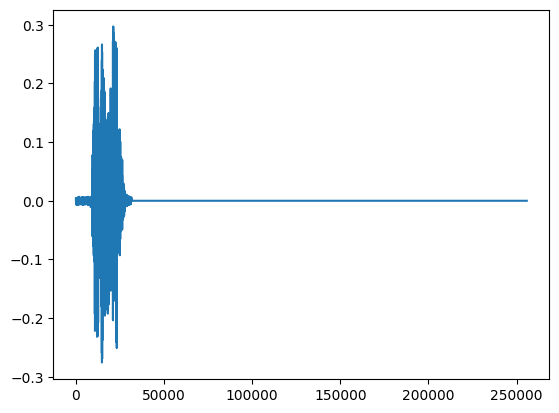

In [7]:
for i, output_list in enumerate(audioIterator):
    for x in range(len(output_list[0])):
        for audio_tensor, label, roi in zip(output_list[0][x], output_list[1], output_list[2]):
            print("Audio shape:     ", audio_tensor.shape)
            print("Label:           ", label)
            print("Roi:             ", roi)
            draw_patches(audio_tensor, label, "cpu")
    break
audioIterator.reset()